## Driving Process Management

- Fuel management is one of the important management factors because bus transportation companies can reduce costs.

- Showing an intuitive score is one way to manage the fuel consumption to the bus driver.

- Therefore, We will develop a scoring function for the eco-driving-level (EDL) using pre-processed bus driving data

- Scale of EDL score is from 0 to 100, where 0 represents a good performance and 100 represents a bad performance for fuel usage.

![screensh](https://drive.google.com/uc?export=view&id=1Nv4mxYSYcNeOLBXz73ds1gpEgUdRLMd8)

- In South Korea, the installation of Digital Tacho Graph (DTG) in vehicles that conduct transportation businesses such as city buses and taxis is stipulated by law

- During driving the vehicle, DTG collects driving records and related information of vehicle and driver such as speed, acceleration, brake signal, GPS information, and driver's information.

- Driver's driving process may be inherent in DTG data

![screensh](https://movingon.blog.gov.uk/wp-content/uploads/sites/45/2014/04/digital-tachograph.jpg)








### 1.Data preparation

#### 1.1 Data import

In [1]:
# Load packages
import io
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Read csv file
df = pd.read_csv('Driving_Event_Fuel_data_preprocessed.csv')

#### 1.2 Data description
- Each data point represents **counts** of each driving behavior
- Each row represents a trip, that is, a single driving operation (between start and end of driving)
- file_index and bus_num can be ignored.

##### * Driving behaviors affecting fuel usage (Derived by previous research)
- Sharp Acceleration (SA, 급가속)
- Sharp Deceleration (SD, 급감속) 
- Prolonged Acceleration (PA, 장기 가속) 
- Prolonged Idling (PI, 장기 공회전) 
- Low-speed Running (LR, 저속운행) 
- High-speed Cruising (HC, 고속 등속 운행) 

##### * Target variable
 - Usage of fuel per kilometer (L/km)

In [4]:
#Show sample of dataframe
df.head(10)

,SA,SD,PA,PI,LR,HC,fuel,bus_num,file_index
0,2,6,98,0,274,2480,14.651,##########kd000010,0_3
1,5,14,353,0,605,2894,24.255,##########kd000010,0_6
2,0,1,165,0,0,2618,16.992,##########kd000010,0_7
3,0,0,35,0,0,942,7.648,##########kd000010,1_9
4,0,0,42,0,0,2330,15.656,##########kd000010,1_10
5,3,1,92,0,225,3442,18.317,##########kd000010,1_12
6,0,3,55,0,0,3303,15.313,##########kd000108,2_5
7,2,6,98,0,274,2480,14.651,##########kd000010,0_3
8,5,14,353,0,605,2894,24.255,##########kd000010,0_6
9,0,1,165,0,0,2618,16.992,##########kd000010,0_7


In [5]:
#Show statistic values
df.describe()


,SA,SD,PA,PI,LR,HC,fuel
count,7466.000000,7466.000000,7466.000000,7466.000000,7466.000000,7466.000000,7466.000000
mean,6.781677,14.150013,303.811814,145.306858,634.283820,1780.261452,12.464910
std,33.011995,31.496997,245.448925,221.531641,731.575919,960.308392,5.346402
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.001000
25%,0.000000,1.000000,123.000000,0.000000,63.000000,1006.000000,7.784750
50%,2.000000,7.000000,252.000000,0.000000,387.000000,1594.500000,11.741000
75%,8.000000,20.000000,417.000000,223.000000,962.000000,2437.000000,16.426000
max,1730.000000,1684.000000,1559.000000,2812.000000,5143.000000,5059.000000,24.984000


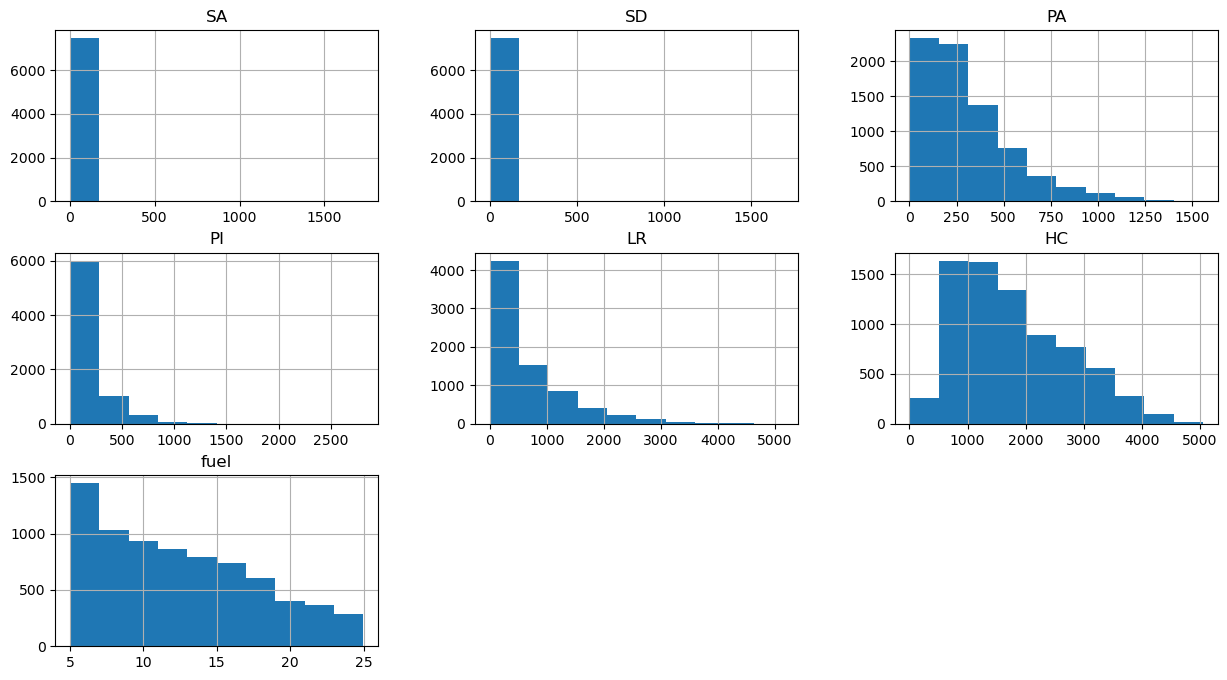

In [6]:
#Check the distribution of each variable and target variable.
df.hist(figsize=(15,8));


### 2.Data preprocessing

#### 2.1 Drop disused columns

In [7]:
df.drop(columns = ['bus_num','file_index'], inplace = True)
df.head()

,SA,SD,PA,PI,LR,HC,fuel
0,2,6,98,0,274,2480,14.651
1,5,14,353,0,605,2894,24.255
2,0,1,165,0,0,2618,16.992
3,0,0,35,0,0,942,7.648
4,0,0,42,0,0,2330,15.656


#### 2.2 Split Train and test dataset
- Ratio of size of train and test dataset is 8:2

In [8]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size = 0.2, random_state = 0)
train_df.reset_index(inplace = True , drop = True)
test_df.reset_index(inplace = True, drop = True)

#### 2.3 Min max scaler for independent variables
- Normalization : convert each input variable separately to the range 0-1
- Reason : to prevent the magnitude of value does not affect the estimation of the variables' impact(i.e.,
coefficient)
- $X_{scaled} = \frac{x - x_{min}}{x_{max} - x_{min}}$


In [9]:
#import minmax scaler from sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler

In [10]:
#write a function to convert train data set using minmax scaler
def train_minmaxscaler(df, x_col, feature_range):
    scale_df = df.copy()
    
    x_scaler = MinMaxScaler(feature_range = feature_range)
    x_scaler = x_scaler.fit(df.loc[:,x_col])
    scale_df.loc[:,x_col] = x_scaler.transform(df.loc[:,x_col])
    return scale_df, x_scaler

In [11]:
x_col = [i for i in train_df.columns if i not in ['fuel']]
feature_range = (0,1)
train_df, x_scaler = train_minmaxscaler(train_df, x_col, feature_range)

In [12]:
train_df.head(5)

,SA,SD,PA,PI,LR,HC,fuel
0,0.006936,0.012470,0.524246,0.061522,0.429122,0.526982,21.441
1,0.015607,0.037411,0.631717,0.140825,0.493409,0.218225,15.146
2,0.000000,0.003563,0.129096,0.000000,0.025147,0.522040,15.011
3,0.001734,0.004157,0.123198,0.179587,0.156561,0.537853,18.461
4,0.009827,0.011876,0.678244,0.063300,0.652809,0.266653,13.737


In [13]:
train_df.describe()

,SA,SD,PA,PI,LR,HC,fuel
count,5972.000000,5972.000000,5972.000000,5972.000000,5972.000000,5972.000000,5972.000000
mean,0.003960,0.008439,0.200145,0.051110,0.128538,0.350950,12.444706
std,0.020329,0.019780,0.161194,0.078640,0.148802,0.189586,5.356604
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.001000
25%,0.000000,0.000594,0.079948,0.000000,0.012168,0.198013,7.779000
50%,0.001156,0.004157,0.165793,0.000000,0.078077,0.312611,11.652000
75%,0.004624,0.011876,0.276540,0.078592,0.196106,0.478751,16.433250
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,24.984000


In [14]:
#write a function to convert test data set using minmax scaler
def test_minmaxscaler(df, x_col, x_scaler):
    scale_df = df.copy()
    scale_df.loc[:,x_col] = x_scaler.transform(df.loc[:,x_col])
    
    return scale_df

In [15]:
#use the x_scaler of training dataset.
test_df = test_minmaxscaler(test_df, x_col, x_scaler)

In [16]:
test_df.head(5)

,SA,SD,PA,PI,LR,HC,fuel
0,0.008092,0.008314,0.169725,0.061878,0.137092,0.131449,7.753
1,0.002890,0.011876,0.171691,0.046230,0.125127,0.203993,8.426
2,0.001734,0.005344,0.109436,0.000000,0.066721,0.398893,13.886
3,0.009249,0.009501,0.363041,0.000000,0.387954,0.105554,7.326
4,0.002890,0.002969,0.135649,0.061878,0.096735,0.627594,18.035


In [17]:
test_df.describe()

,SA,SD,PA,PI,LR,HC,fuel
count,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000
mean,0.003760,0.008259,0.194875,0.053927,0.129007,0.355696,12.545675
std,0.012955,0.013581,0.159423,0.079329,0.146641,0.190777,5.306441
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.001000
25%,0.000000,0.000594,0.080603,0.000000,0.016021,0.203400,7.840250
50%,0.001156,0.004157,0.164155,0.023115,0.082640,0.324768,12.074500
75%,0.004624,0.011876,0.259174,0.083926,0.192354,0.492093,16.371250
max,0.265896,0.218527,1.021625,0.586771,1.042993,0.943269,24.952000


### 3.Estimation of scoring function using Linear Regression

![screensh](https://miro.medium.com/max/1160/1*Jfx203VYFtcM958gbFsiXA.png)

- Scikit-learn linear regression
- Statsmodels linear regression (Ordinary Least Square)

#### 3.0 Define Metric

In [18]:
from sklearn.metrics import r2_score, mean_squared_error

In [19]:
# define r2_score, mean_squared_error
def test_metric(y, y_pred):
    rmse = mean_squared_error(y, y_pred) ** 0.5
    r2 = r2_score(y, y_pred)
    return rmse, r2


#### 3.1 Statsmodels linear regression (Ordinary Least Square)

In [20]:
import statsmodels.api as sm

In [21]:
def stat_OLS(train_df, target, drop_for_x= None):
    #seperate indenpendent variable and dependent variable from train and test dataset
    if drop_for_x is not None:
          drop_list = [target, drop_for_x]
    else:
          drop_list = target
    train_x = train_df.drop(columns = drop_list)
    train_y = train_df[[target]]

    #add intercept term into train_x
    train_x = sm.add_constant(train_x)

    #define the model
    model = sm.OLS(train_y, train_x)
    #train the model
    results = model.fit()

    #store the prediction of model
    train_pred = results.predict(train_x)
    new_df = pd.DataFrame()
    new_df["prediction"] = train_pred

    #print the result
    print('Stats Linear Regression')
    print(results.summary())
    return new_df, results

In [22]:
OLS_result_df, score_function = stat_OLS(train_df, "fuel")

Stats Linear Regression
                            OLS Regression Results                            
Dep. Variable:                   fuel   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     9917.
Date:                Fri, 28 Oct 2022   Prob (F-statistic):               0.00
Time:                        23:48:52   Log-Likelihood:                -11343.
No. Observations:                5972   AIC:                         2.270e+04
Df Residuals:                    5965   BIC:                         2.275e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9538      0

In [23]:
OLS_result_df.describe()

,prediction
count,5972.000000
mean,12.444706
std,5.106735
min,2.452286
25%,8.039131
50%,11.737474
75%,16.301204
max,29.952667


#### 3.3 Result of fuel usage estimation 
- Usage of Fuel = ${0.954 + 47.715*SA - 16.458*SD +14.595*PA + 5.365*PI -6.563*LR + 24.91*HC}$
- Range of prediction value : 2.452~29.953
- R-squared : 0.909

#### 3.4 Scaling for score function
- Normalization : convert each input variable separately to the range 0-100
- $Y_{scaled} = 100* \frac{y - y_{min}}{y_{max} - y_{min}}$

In [24]:
y_max = OLS_result_df["prediction"].max()
y_min = OLS_result_df["prediction"].min()

In [25]:
def score_minmaxscaler(df, y_max, y_min):
    # add code
    scale_df = df.copy()
    y = scale_df['fuel']
    scale_df['normalized_fuel'] = 100 * (y - y_min) / (y_max - y_min)
    return scale_df

In [26]:
scaled_train_df = score_minmaxscaler(train_df, y_max, y_min)

In [27]:
scaled_OLS_result_df, score_function = stat_OLS(scaled_train_df, "normalized_fuel", drop_for_x = "fuel")

Stats Linear Regression
                            OLS Regression Results                            
Dep. Variable:        normalized_fuel   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     9917.
Date:                Fri, 28 Oct 2022   Prob (F-statistic):               0.00
Time:                        23:48:52   Log-Likelihood:                -19053.
No. Observations:                5972   AIC:                         3.812e+04
Df Residuals:                    5965   BIC:                         3.817e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.4490      0

In [28]:
scaled_OLS_result_df.describe()

,prediction
count,5.972000e+03
mean,3.633557e+01
std,1.856969e+01
min,8.881784e-15
25%,2.031552e+01
50%,3.376385e+01
75%,5.035900e+01
max,1.000000e+02


#### 3.5 Score function for Eco driving level 

- Eco driving level = ${-5.449 + 173.51*SA - 59.846*SD +53.072*PA + 19.509*PI -23.866*LR + 94.176*HC}$
- Range of prediction value : 0 ~ 100
- R-squared : 0.909

### 4.Validation of scoring function


In [29]:
#substitute test dataset into our score function for validation
scaled_test_df = score_minmaxscaler(test_df, y_max, y_min)
scaled_test_x = scaled_test_df.drop(columns = ['fuel','normalized_fuel'])
#add intercept term into train_x
scaled_test_x = sm.add_constant(scaled_test_x)
#prediction for test dataset
test_pred = score_function.predict(scaled_test_x)
scaled_test_df['prediction'] = test_pred
#calculate r2 and rmse score of prediction 
rmse, r2 = test_metric(scaled_test_df['normalized_fuel'], test_pred)

print("rmse : {}".format(rmse))
print("r2 : {0}".format(r2))

rmse : 5.932824230970032
r2 : 0.9054014437727474


### 5.Checking the validation result with visualization

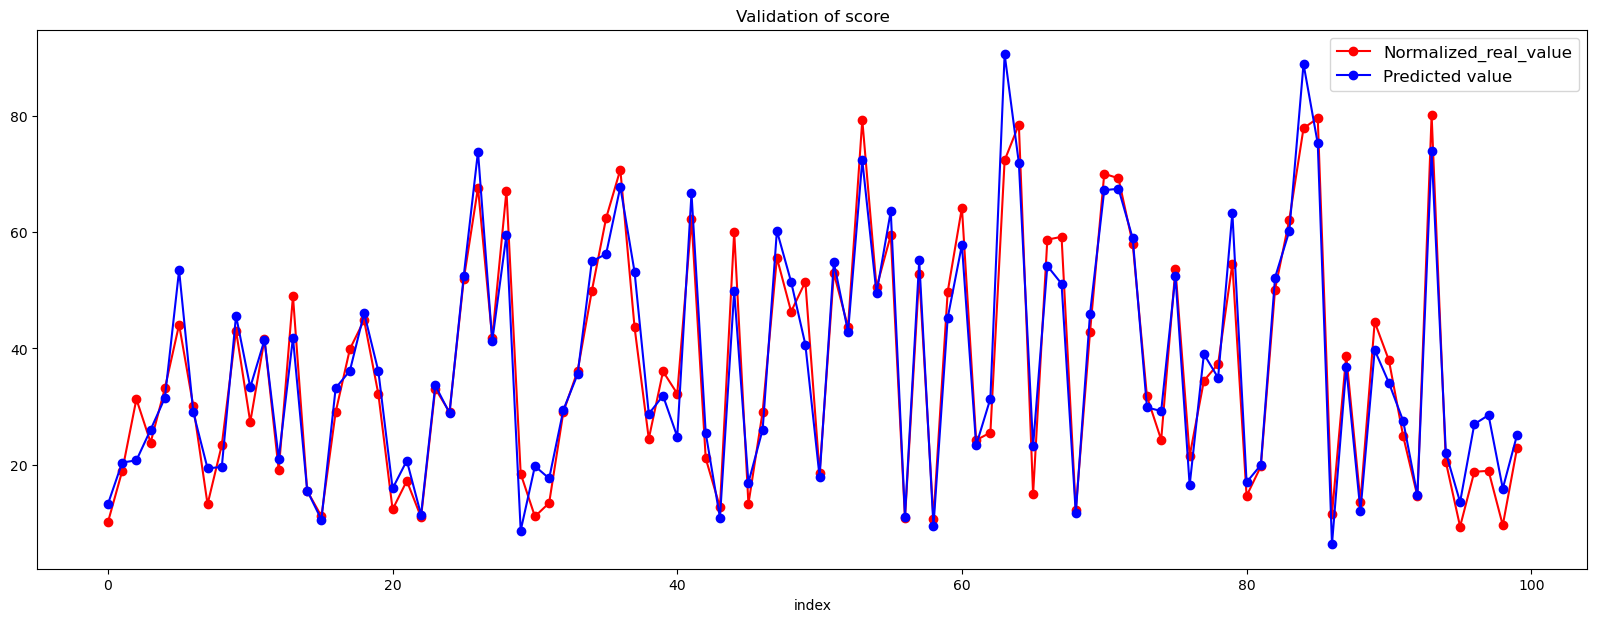

In [30]:
#print plot
plt_df = scaled_test_df.sample(n = 100, random_state = 0)
plt.figure(figsize=(20,7))
plt.title('Validation of score')
plt.plot([i for i in range(len(plt_df['normalized_fuel']))], plt_df['normalized_fuel'],
         label = 'Normalized_real_value', color = 'red', marker = 'o', linestyle = '-')
plt.plot([i for i in range(len(plt_df['normalized_fuel']))], plt_df['prediction'],
         label = 'Predicted value', color = 'blue', marker = 'o', linestyle = '-')
plt.xlabel('index')
plt.legend(fontsize = 12, markerscale = 1, loc = 'upper right')
#plt.tight_layout()
plt.show()

### Additional) 6. XGBoost & SHAP


In [31]:
#!pip install shap
import shap
from xgboost import XGBRegressor, plot_importance 

#### 6.1 XGBoost - fuel prediction

In [32]:
train_x = train_df.drop(columns = 'fuel')
train_y = train_df[['fuel']]

test_x = test_df.drop(columns = 'fuel')
test_y = test_df[['fuel']]

In [33]:
#define the model
XGB = XGBRegressor()

#train the model
XGB.fit(train_x, train_y)
# predict the model 
y_pred_train = XGB.predict(train_x)
#test the model
y_pred_test = XGB.predict(test_x)
#calculate r2 and rmse score of prediction 
r2, rmse = test_metric(test_y, y_pred_test)
print("rmse : {}".format(rmse))
print("r2 : {0}".format(r2))

rmse : 0.9390962198135577
r2 : 1.3091218314353583


#### 6.1.1 Scaling for score function

In [34]:
# define y_max, y_min
y_max = y_pred_train.max()
y_min = y_pred_train.min()

In [35]:
# scale the train data with scaled target variable
scaled_train_df = score_minmaxscaler(train_df, y_max, y_min)
scaled_train_x = scaled_train_df.drop(columns = ['fuel','normalized_fuel'])
scaled_train_y = scaled_train_df[['normalized_fuel']]

# scale the test data with scaled target variable
scaled_test_df = score_minmaxscaler(test_df, y_max, y_min)
scaled_test_x = scaled_test_df.drop(columns = ['fuel','normalized_fuel'])
scaled_test_y = scaled_test_df[['normalized_fuel']]


In [36]:
# define new model. 
XGB_model_scaled = XGBRegressor()
# train the model
XGB_model_scaled.fit(scaled_train_x, scaled_train_y)
# prdict the model
y_pred_train = XGB_model_scaled.predict(scaled_train_x)
# test the model
y_pred_test = XGB_model_scaled.predict(scaled_test_x)
scaled_test_df['prediction'] = y_pred_test
# calculate r2 and rmse score of prediction 
r2, rmse = test_metric(scaled_test_y, y_pred_test)
print('\ntest RMSE: {:.4f} | test R-sqaured: {:.4f}'.format(rmse, r2))


test RMSE: 0.9393 | test R-sqaured: 6.5186


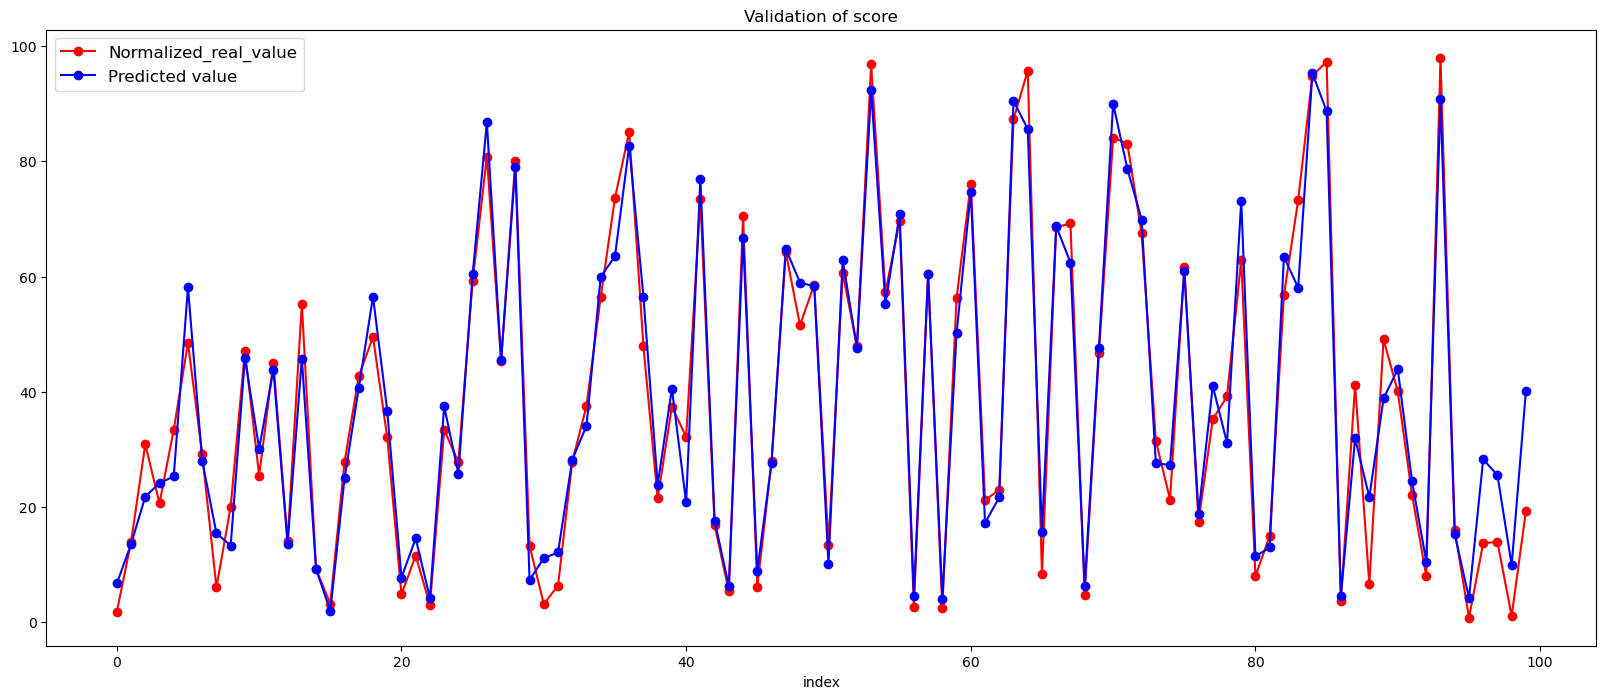

In [37]:
# Checking the validation result with visualization
plt_df = scaled_test_df.sample(n = 100, random_state = 0)
plt.figure(figsize=(20,8))
plt.title('Validation of score')
plt.plot([i for i in range(len(plt_df['normalized_fuel']))], plt_df['normalized_fuel'],
         label = 'Normalized_real_value', color = 'red', marker = 'o', linestyle = '-')
plt.plot([i for i in range(len(plt_df['normalized_fuel']))], plt_df['prediction'],
         label = 'Predicted value', color = 'blue', marker = 'o', linestyle = '-')
plt.xlabel('index')
plt.legend(fontsize = 12, markerscale = 1, loc = 'upper left')
#plt.tight_layout()
plt.show()

#### 6.2 SHAP Model

In [38]:
# define SAHP
shap.initjs()
explainer = shap.TreeExplainer(XGB)
shap_values = explainer.shap_values(scaled_test_x)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


### 6.3 SHAP Analysis

In [39]:
# shap anlaysis for 1 data sample
data_index = 70
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[data_index,:], scaled_test_x.iloc[data_index,:])

In [40]:
# shap analysis for serveral data samples
data_index_start = 0
data_index_end = 100

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[data_index_start:data_index_end,:],
                scaled_test_x.iloc[data_index_start:data_index_end,:])


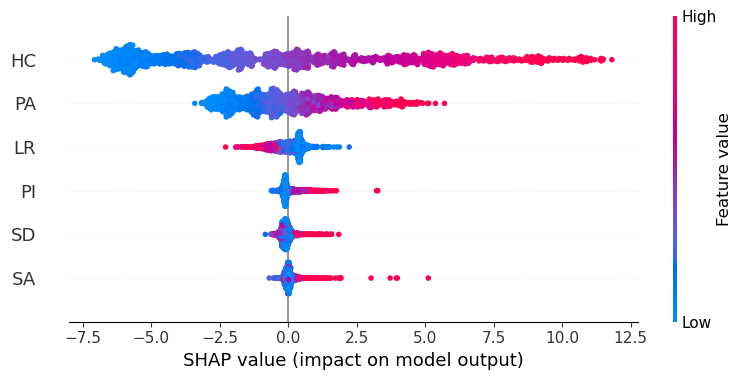

In [41]:
# shap analysis for whole test data samples
shap.summary_plot(shap_values, scaled_test_x)

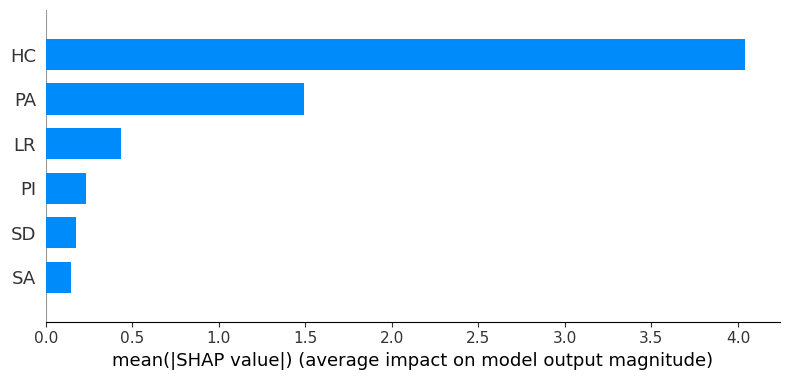

In [42]:
# Mean of shap values per variable
shap.summary_plot(shap_values, scaled_test_x, plot_type='bar')